## Image classification with Vision Transformer
#### https://keras.io/examples/vision/image_classification_with_vision_transformer/

## Setup

In [1]:
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import cv2
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics
from keras.datasets import cifar10
from keras.utils import to_categorical

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Convolution Neural Networks Filter Image
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, UpSampling2D
# Convolution Auto Encoder Filter Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D,Concatenate ,Conv2DTranspose
from keras import optimizers
from keras.models import Model
from keras import backend as K

In [3]:
from keras.layers import Input ,Normalization, Resizing,RandomFlip, RandomRotation,RandomZoom
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D ,LeakyReLU,ReLU, Concatenate,Flatten
from keras import optimizers
from keras.models import Model

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## Load Dataset

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [6]:
# #정규화 사용 시 코드 Vit 모델은 augmentation내 Normalization 있어서 사용하면 안됨
# x_train=x_train.astype('float32')/255.
# x_test=x_test.astype('float32')/255.

In [7]:
# ViT는 원핫인코딩 사용X
# y_train = to_categorical(y_train,10) #원핫 인코딩
# y_test=to_categorical(y_test,10) #원핫 인코딩

## Train Test Split

In [8]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model : ViT

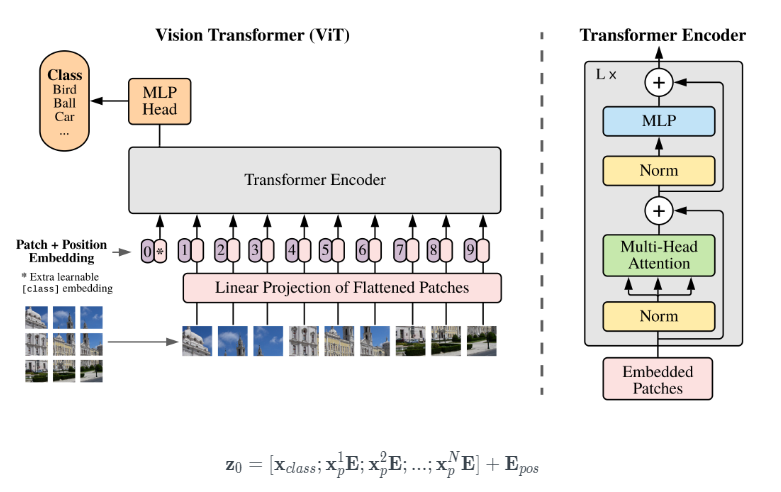

## Configure the hyperparameters

In [9]:
input_shape = (32, 32, 3)
num_classes = 10

In [10]:
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 128 #256은 메모리 에러
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Use data augmentation

In [11]:
data_augmentation = Sequential(
    [
        Normalization(),
        Resizing(image_size, image_size),
        RandomFlip("horizontal"),
        RandomRotation(factor=0.02),
        RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement multilayer perceptron (MLP)

In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x) #활성화 함수 수정 X
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [13]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


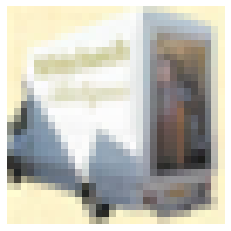

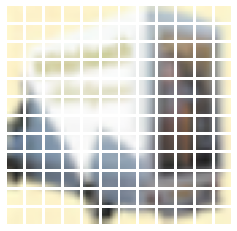

In [14]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model

In [16]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## F1-Score

In [17]:
#https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Compile, train, and evaluate the mode

In [19]:
vit_classifier = create_vit_classifier()
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay)
vit_classifier.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    run_eagerly=True
)
    
#     checkpoint_filepath = "/tmp/checkpoint"
#     checkpoint_callback = keras.callbacks.ModelCheckpoint(
#         checkpoint_filepath,
#         monitor="val_accuracy",
#         save_best_only=True,
#         save_weights_only=True,
#     )
#model.load_weights(checkpoint_filepath)

In [20]:
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                                              

 multi_head_attention_3 (MultiH  (None, 144, 64)     66368       ['layer_normalization_6[0][0]',  
 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 144, 64)      0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 144, 64)     128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (Dense)                (None, 144, 128)     8320        ['layer_normalization_7[0][0]']  
          

                                                                                                  
 dropout_13 (Dropout)           (None, 144, 64)      0           ['dense_14[0][0]']               
                                                                                                  
 add_13 (Add)                   (None, 144, 64)      0           ['dropout_13[0][0]',             
                                                                  'add_12[0][0]']                 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 144, 64)     128         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 144, 64)     66368       ['layer_normalization_14[0][0]', 
 eadAttent

In [ ]:
start = time.time()
history = vit_classifier.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
        epochs=num_epochs,
    validation_split=0.1,
)
end = time.time()
running_time = end - start
print("소요시간 : "+str(running_time))

Epoch 1/100
352/352 [==============================] - 154s 436ms/step - loss: 2.2046 - accuracy: 0.2687 - top-5-accuracy: 0.7680 - val_loss: 1.6760 - val_accuracy: 0.4112 - val_top-5-accuracy: 0.8806
Epoch 2/100
352/352 [==============================] - 155s 440ms/step - loss: 1.7289 - accuracy: 0.3784 - top-5-accuracy: 0.8641 - val_loss: 1.4858 - val_accuracy: 0.4738 - val_top-5-accuracy: 0.9176
Epoch 3/100
352/352 [==============================] - 155s 439ms/step - loss: 1.5647 - accuracy: 0.4370 - top-5-accuracy: 0.8990 - val_loss: 1.3116 - val_accuracy: 0.5252 - val_top-5-accuracy: 0.9420
Epoch 4/100
352/352 [==============================] - 155s 440ms/step - loss: 1.4437 - accuracy: 0.4789 - top-5-accuracy: 0.9202 - val_loss: 1.2060 - val_accuracy: 0.5694 - val_top-5-accuracy: 0.9548
Epoch 5/100
352/352 [==============================] - 154s 437ms/step - loss: 1.3514 - accuracy: 0.5155 - top-5-accuracy: 0.9319 - val_loss: 1.1270 - val_accuracy: 0.5994 - val_top-5-accuracy: 0.

## Test Data 20 Class F1-Score

In [28]:
pred= vit_classifier.predict(x_test)

313/313 [==============================] - 16s 50ms/step


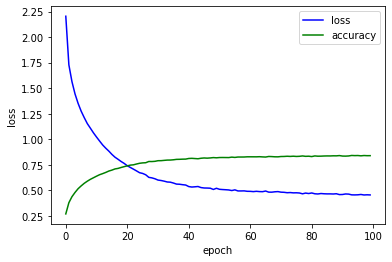

In [29]:
vit_loss = history.history['loss']
#vit_f1_score = history.history["f1_score"]
vit_acc= history.history["accuracy"]
plt.figure()
plt.plot(range(num_epochs), vit_loss, 'b', label="loss")
#plt.plot(range(num_epochs), vit_f1_score, 'r', label="f1_score")
plt.plot(range(num_epochs), vit_acc, 'g', label="accuracy")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [30]:
#pred의 경우 50개의 값 중 가장 높은 predict값을 가지는 인덱스를 라벨(클래스)로 사용
y_pred=[]
y_true=[]
for i in range(len(pred)):
    tmp1 = pred[i].argmax() #최대값을 가지는 인덱스
    tmp2 = y_test[i][0] #최대값을 가지는 인덱스 -> 0과 1만 가지므로 1인 인덱스 반환
    y_pred.append(tmp1)
    y_true.append(tmp2)

In [31]:
from sklearn.metrics import f1_score
print("각 클래스별 F1-Score의 평균: {0} ".format(f1_score(y_true, y_pred, average = None).mean()))

각 클래스별 F1-Score의 평균: 0.7751266838415005 


In [32]:
print(metrics.confusion_matrix(y_true, y_pred))
print(metrics.classification_report(y_true, y_pred, digits=3))

[[821  14  21   9  15   3   8   7  44  58]
 [ 11 844   3   4   1   5   5   0  11 116]
 [ 55   2 687  37  86  34  46  25  10  18]
 [ 24   4  35 570  66 166  52  35  13  35]
 [ 19   3  50  23 799  22  26  43   7   8]
 [ 16  10  29 127  53 672  31  42   5  15]
 [  8   6  32  35  42  19 835   8   1  14]
 [ 14   4  16  22  50  28   5 822   4  35]
 [ 52  37   9   7   6   4   3   4 835  43]
 [ 21  48   3  13   3   4   3   8  16 881]]
              precision    recall  f1-score   support

           0      0.789     0.821     0.805      1000
           1      0.868     0.844     0.856      1000
           2      0.776     0.687     0.729      1000
           3      0.673     0.570     0.617      1000
           4      0.713     0.799     0.753      1000
           5      0.702     0.672     0.687      1000
           6      0.823     0.835     0.829      1000
           7      0.827     0.822     0.824      1000
           8      0.883     0.835     0.858      1000
           9      0.720     

In [33]:
_, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test Accuracy: {round(accuracy * 100, 2)}%")
print(f"Test Top-5-Accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 17s 55ms/step - loss: 0.6595 - accuracy: 0.7766 - top-5-accuracy: 0.9861
Test Accuracy: 77.66%
Test Top-5-Accuracy: 98.61%
